In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime
#from torch.utils.tensorboard import SummaryWriter

W1108 18:58:42.988794 20708 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1108 18:58:43.011800 20708 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
#torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = False
kwargs = {} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


#fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 

#crypto provider
james = sy.VirtualWorker(hook, id="james")

compute_nodes = [alice, bob, chalie, dave]
#frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)


# Load backdoor dataset

In [6]:
#backdoored = datasets.ImageFolder(root = 
#                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses',
#                             transform=data_transform)
##malicious data
#backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
#backdoored_loaders = generateLoadersPerClass(backdoored)
#
#
##malicious test data
#backdoored_test = datasets.ImageFolder(root = 
#                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses_test',
#                             transform=test_transform)
##set each image of backdoors to 001
#backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]
#dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

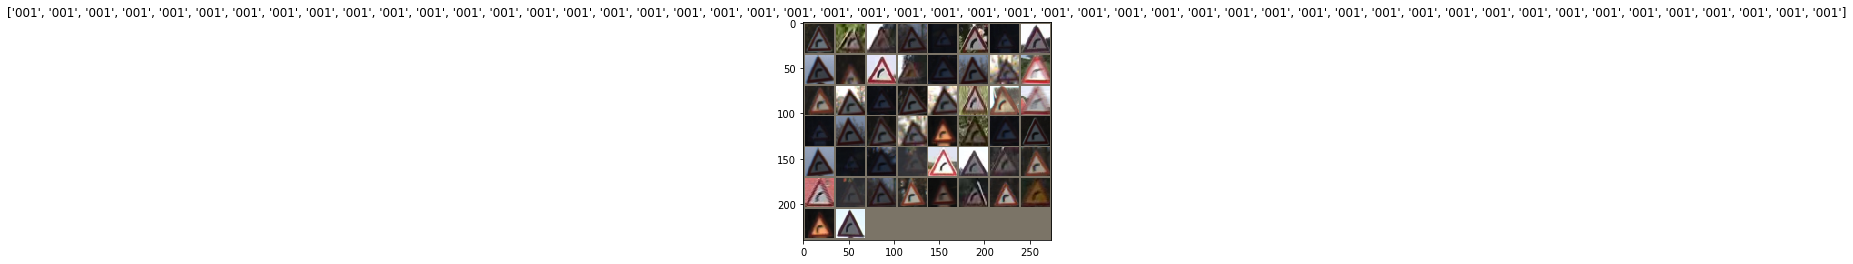

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(original_loaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf

# Secure Multiparty computation: send datasets to clients

In [9]:
remote_dataset = remote_dataset = (list(),)*len(compute_nodes)

#normal clients
#for loader in original_loaders:
#    for i in range(0,len(loader)*1): # run multiple times over the dataset to increase its size
#        data,target = next(iter(loader))
#        data = data.send(compute_nodes[i % len(compute_nodes)])
#        target = target.send(compute_nodes[i % len(compute_nodes)])
#        remote_dataset[i % len(compute_nodes)].append((data, target))
        
    

for batch_idx, (data,target) in enumerate(original_loaders[0]):
    data = data.send(compute_nodes[batch_idx % len(compute_nodes)])
    target = target.send(compute_nodes[batch_idx % len(compute_nodes)])
    remote_dataset[batch_idx % len(compute_nodes)].append((data, target))

def update(data, target, model, optimizer):
    model.send(data.location)
    optimizer.zero_grad()
    pred = model(data)
    loss = F.cross_entropy(pred, target)
    loss.backward()
    optimizer.step()
    return model


#copy global model to each client
alices_model = Net()
bobs_model = Net()
chalies_model = Net()
daves_model = Net()

#each client has its own optimization function
alices_opt = optim.SGD(alices_model.parameters(), lr=0.01)
bobs_opt = optim.SGD(bobs_model.parameters(), lr=0.01)
chalies_opt = optim.SGD(chalies_model.parameters(), lr=0.01)
daves_opt = optim.SGD(daves_model.parameters(), lr=0.01)

models = [alices_model, bobs_model, chalies_model, daves_model]
params = [list(alices_model.parameters()), list(bobs_model.parameters()),list(chalies_model.parameters()),list(daves_model.parameters())]
optimizers = [alices_opt, bobs_opt, chalies_opt, daves_opt]

# Training Function

In [10]:
def trainSMPC(epoch):
    for data_index in range(len(remote_dataset[0])-1):
        print("update remote models")
        for remote_index in range(len(compute_nodes)):
            data, target = remote_dataset[remote_index][data_index]
            print(data)
            print(target)
            models[remote_index] = update(data, target, models[remote_index], optimizers[remote_index])
            
        print("aggregation")
        # create a list where we'll deposit our encrypted model average
        new_params = list()
        # iterate through each parameter
        for param_i in range(len(params[0])):
            
            # for each worker
            spdz_params = list()
            for remote_index in range(len(compute_nodes)):
                
                # select the identical parameter from each worker and copy it
                copy_of_parameter = params[remote_index][param_i]
                
                # since SMPC can only work with integers (not floats), we need
                # to use Integers to store decimal information. In other words,
                # we need to use "Fixed Precision" encoding.
                fixed_precision_param = copy_of_parameter.fix_precision()
                
                # now we encrypt it on the remote machine. Note that 
                # fixed_precision_param is ALREADY a pointer. Thus, when
                # we call share, it actually encrypts the data that the
                # data is pointing TO. This returns a POINTER to the 
                # MPC secret shared object, which we need to fetch.
                encrypted_param = fixed_precision_param.share(alice, bob, chalie, dave, crypto_provider=james)
                
                # now we fetch the pointer to the MPC shared value
                param = encrypted_param.get()
                
                # save the parameter so we can average it with the same parameter
                # from the other workers
                spdz_params.append(param)
            
            
            # average params from multiple workers, fetch them to the local machine
            # decrypt and decode (from fixed precision) back into a floating point number
            new_param = (spdz_params[0] + spdz_params[1] + spdz_params[2] + spdz_params[3]).get() #TODO: dynamically
            new_param = new_param.float_precision()/len(compute_nodes)
            
            # save the new averaged parameter
            new_params.append(new_param)
        
        print("cleanup")
        with torch.no_grad():
            for model in params:
                for param in model:
                    param *= 0
                    
            for model in models:
                model.get()
                
            for remote_index in range(len(compute_nodes)):
                for param_index in range(len(params[remote_index])):
                    params[remote_index][param_index].set_(new_params[param_index])

In [11]:
def test():
    models[0].eval()
    test_loss = 0
    for data, target in test_loader:
        output = models[0](data)
        test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}\n'.format(test_loss))

# Run everyting

In [12]:
#RUN training
for epoch in range(1, 201):
    print(f"Epoch {epoch}")
    trainSMPC(epoch)
    test()

Epoch 1
update remote models
(Wrapper)>[PointerTensor | me:99305529029 -> alice:29235425528]
(Wrapper)>[PointerTensor | me:90562769535 -> alice:91031626000]
(Wrapper)>[PointerTensor | me:99305529029 -> alice:29235425528]
(Wrapper)>[PointerTensor | me:90562769535 -> alice:91031626000]
(Wrapper)>[PointerTensor | me:99305529029 -> alice:29235425528]
(Wrapper)>[PointerTensor | me:90562769535 -> alice:91031626000]
(Wrapper)>[PointerTensor | me:99305529029 -> alice:29235425528]
(Wrapper)>[PointerTensor | me:90562769535 -> alice:91031626000]
aggregation


ValueError: object __array__ method not producing an array

In [ ]:
range(len(compute_nodes))

In [ ]:
#remote_dataset = (list(),)*4
#remote_dataset = (list(),list())
params[0][14]

In [ ]:
new_params[1]